In [124]:
import numpy as np
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import bernoulli

# Regression

In [125]:
ambient_dimension = 128
avg_num = int(1e+2) # number of experiment average
noise_std = 0.5
factor = 0.8
snr = 4


# Data generation model:
# 1. 1-sparse vector
true_theta = np.zeros([ambient_dimension, 1])
signal_position = [1]
for i in signal_position:
    true_theta[i] = 1
# 2. random gaussian
true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
true_theta /= LA.norm(true_theta)
true_theta = true_theta.reshape(-1, 1)
# 3. dense signal with spikes
#true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
#for i in range(20):
#    true_theta[i] = 0
#spike_strength = 10000
#true_theta[0] = np.sqrt(spike_strength) * LA.norm(true_theta)

# 2. input data distribution
Sigma = np.identity(ambient_dimension)
decay = 1
for i in range(ambient_dimension):
    Sigma[i, i] = decay ** abs(i) if i in signal_position else 0
    Sigma[i, i] = decay ** abs(i)
alpha = snr * noise_std ** 2 / (true_theta.T.dot(Sigma).dot(true_theta)[0][0])
Sigma *= alpha

#for i in signal_position:
#    true_theta[i] /= np.sqrt(Sigma[i, i])
#for i in range(20):
#    Sigma[i, i] = 1
#for i in range(20, ambient_dimension):
#    Sigma[i, i] = 0.2

#for i in range(ambient_dimension):
#    Sigma[i, i] = random.random()

In [126]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    S = LA.inv(X.T.dot(X) + n * ridge * reg).dot(X.T) if ridge > 0 else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_finite_ridge_est(X, y, ridge, m, noise):
    n = X.shape[0]
    y_clean = y - noise
    X1 = np.tile(X, [m, 1])
    y1 = np.tile(y, [m, 1])
    y1_clean = np.tile(y_clean, [m, 1])
    noise_1 = np.tile(noise, [m, 1])
    X1 = X1 + np.random.multivariate_normal([0] * ambient_dimension, ridge * np.identity(ambient_dimension), m * n)
    Cov = X1.T.dot(X1)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X1.T)
    return S.dot(y1), S.dot(y1_clean), S.dot(noise_1)

def get_het_ridge_est(X, y, ridge_list):
    d = X.shape[1]
    n = X.shape[0]
    reg = n * np.identity(d)
    for i in range(d):
        reg[i, i] *= ridge_list[i]
    S = LA.pinv(X.T.dot(X) + reg).dot(X.T)
    return S.dot(y)

def get_pepper_est(X, y, ridge, p):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    psi = p / (1 - p)
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    S = LA.inv(Cov + psi / (1 - p) * n * ridge * reg + psi * diag).dot(X.T) if (ridge > 0 or p > 0) else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_lse_est_2(X, y):
    Cov = X.T.dot(X)
    mu = X.mean(axis=0).reshape(-1, 1)
    n = X.shape[0]
    #Z1 = n * mu.dot(mu.T)
    Z1 = Cov - 0.5 * np.diag(np.diag(Cov))
    A1 = np.concatenate((Cov, Z1), axis=1)
    A2 = np.concatenate((Z1.T, Cov), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    #B = np.concatenate((X.T, mu.dot(np.ones([1, n]))), axis=0).dot(y)
    B = np.concatenate((X.T, X.T), axis=0).dot(y)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    return LA.pinv(Z).dot(B)

def get_knockoff_est(X, y, D):
    Cov = X.T.dot(X)
    A = Cov.dot(np.identity(ambient_dimension) - LA.inv(Sigma).dot(D))
    A1 = np.concatenate((Cov, A), axis=1)
    B = 2 * D - D.dot(LA.inv(Sigma)).dot(D) + Cov - Cov.dot(LA.inv(Sigma)).dot(D) - D.dot(LA.inv(Sigma)).dot(Cov) + \
        D.dot(LA.inv(Sigma)).dot(Cov).dot(LA.inv(Sigma)).dot(D)
    A2 = np.concatenate((A.T, B), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    C = np.concatenate((np.identity(ambient_dimension), np.identity(ambient_dimension) - D.dot(LA.inv(Sigma))), axis=0)
    return LA.pinv(Z).dot(C).dot(X.T).dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    Z = Cov + p / (1 - p) * diag
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_finite_crop_est(X, y, p, m, noise):
    n = X.shape[0]
    X1 = np.tile(X, [m, 1])
    y1 = np.tile(y, [m, 1])
    y1_clean = np.tile(y - noise, [m, 1])
    noise_1 = np.tile(noise, [m, 1])
    mask = 1 / (1 - p) * bernoulli.rvs(1 - p, size=[m * n, ambient_dimension])
    X1 = mask * X1
    Cov = X1.T.dot(X1)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X1.T)
    return S.dot(y1), S.dot(y1_clean), S.dot(noise_1)

def get_crop_est_bar(X, y, p):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Z = Cov + p / (1 - p) * n * Sigma
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

# heterogeneous mask
def get_het_crop_est(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    p1 = p / het_ratio
    diag = np.diag(np.diag(Cov))
    reg = diag
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_het_crop_est_2(X, y, p_list):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    reg = diag
    for i in range(Cov.shape[0]):
        reg[i, i] *= p_list[i] / (1 - p_list[i])
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_het_crop_est_bar_2(X, y, p_list):
    Cov = X.T.dot(X)
    n = X.shape[0]
    reg = n * Sigma
    for i in range(Cov.shape[0]):
        reg[i, i] *= p_list[i] / (1 - p_list[i])
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_het_crop_est_bar(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    n = X.shape[0]
    p1 = p / het_ratio
    reg = n * Sigma
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_risk(a, b):
    diff = a - b
    return  diff.T.dot(Sigma).dot(diff)[0, 0]

def get_norm(theta):
    return  theta.T.dot(Sigma).dot(theta)[0, 0]

In [127]:
# Choose the type of augmentation:
# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
#ridge_params = np.concatenate((np.zeros(1), np.power(2, np.linspace(-10, -6, num=0)), np.power(2, np.linspace(-5, 2, num=10)), np.power(2, np.linspace(2, 20, num=0))))
ridge_params = [0, 0.2, 0.5, 1, 2, 5]
ridge_params = np.concatenate((np.linspace(0, 1, 0), np.linspace(0, 2, 10)))
for i in range(len(ridge_params)):
    ridge_params[i] = ridge_params[i] ** 2
crop_params = np.concatenate((np.linspace(0, 1e-3, num=1), np.linspace(0.05, 0.4, num=5), np.linspace(.5, .99, num=4)))
ridge_params = [1]
crop_params = [0.3]
aug_size = [1, 2, 4, 8, 64, 128]

#ridge_params = [1]
#crop_params = [0.3]
#pepper_params = {"ridge": [1], "drop_prob": [0.3]}

In [128]:
sample_list = range(5, int(ambient_dimension * 1.5), 5)
risk_lse = np.zeros([avg_num, len(sample_list)])
bias_lse = np.zeros([avg_num, len(sample_list)])
var_lse = np.zeros([avg_num, len(sample_list)])

risk_ridge = np.zeros([avg_num, len(ridge_params), len(sample_list)])
bias_ridge = np.zeros([avg_num, len(ridge_params), len(sample_list)])
var_ridge = np.zeros([avg_num, len(ridge_params), len(sample_list)])

risk_ridge_finite = np.zeros([avg_num, len(ridge_params), len(aug_size), len(sample_list)])
bias_ridge_finite = np.zeros([avg_num, len(ridge_params), len(aug_size), len(sample_list)])
var_ridge_finite = np.zeros([avg_num, len(ridge_params), len(aug_size), len(sample_list)])

risk_crop = np.zeros([avg_num, len(crop_params), len(sample_list)])
bias_crop = np.zeros([avg_num, len(crop_params), len(sample_list)])
var_crop = np.zeros([avg_num, len(crop_params), len(sample_list)])
err_crop = np.zeros([avg_num, len(crop_params), len(sample_list)])

risk_crop_finite = np.zeros([avg_num, len(crop_params), len(aug_size), len(sample_list)])
bias_crop_finite = np.zeros([avg_num, len(crop_params), len(aug_size), len(sample_list)])
var_crop_finite = np.zeros([avg_num, len(crop_params), len(aug_size), len(sample_list)])

# Simulate risk
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):

    # generate training data
    X = np.zeros([sample_list[-1], ambient_dimension])
    y = np.zeros([sample_list[-1], 1])
    noise_vec = np.zeros([sample_list[-1], 1])
    for j in range(X.shape[0]):
        X[j, :] = np.random.multivariate_normal([0] * ambient_dimension, Sigma).reshape(-1)
        noise_vec[j, :] = np.random.normal(0, noise_std)
        y[j, :] = np.inner(true_theta.reshape(-1), X[j, :]) + noise_vec[j, :]
    for k in range(len(sample_list)):
        sample = sample_list[k]
        X_tr = X[:sample, :]
        y_tr = y[:sample, :]
        noise_tr = noise_vec[:sample, :]
        theta_lse = get_lse_est(X_tr, y_tr)
        theta_bias = get_lse_est(X_tr, y_tr - noise_tr)
        theta_var = get_lse_est(X_tr, noise_tr)
        risk_lse[i, k] = get_risk(theta_lse, true_theta)
        bias_lse[i, k] = get_risk(theta_bias, true_theta)
        var_lse[i, k] = get_risk(theta_var, 0)

        # get loss
        for j in range(len(ridge_params)):
            theta = get_ridge_est(X_tr, y_tr, ridge_params[j])
            theta_bias = get_ridge_est(X_tr, y_tr - noise_tr, ridge_params[j])
            theta_var = get_ridge_est(X_tr, noise_tr, ridge_params[j])
            risk_ridge[i, j, k] = get_risk(theta, true_theta)
            bias_ridge[i, j, k] = get_risk(theta_bias, true_theta)
            var_ridge[i, j, k] = get_risk(theta_var, 0)
            for l in range(len(aug_size)):
                theta, theta_bias, theta_var = get_finite_ridge_est(X_tr, y_tr, ridge_params[j], aug_size[l], noise_tr)
                #theta_bias = get_finite_ridge_est(X_tr, y_tr - noise_tr, ridge_params[j], aug_size[l])
                #theta_var = get_finite_ridge_est(X_tr, noise_tr, ridge_params[j], aug_size[l])
                risk_ridge_finite[i, j, l, k] = get_risk(theta, true_theta)
                bias_ridge_finite[i, j, l, k] = get_risk(theta_bias, true_theta)
                var_ridge_finite[i, j, l, k] = get_risk(theta_var, 0)

        for j in range(len(crop_params)):
            theta = get_crop_est(X_tr, y_tr, crop_params[j])
            theta_bias = get_crop_est_bar(X_tr, y_tr - noise_tr, crop_params[j])
            theta_var = get_crop_est_bar(X_tr, noise_tr, crop_params[j])
            theta_bar = get_crop_est_bar(X_tr, y_tr, crop_params[j])
            risk_crop[i, j, k] = get_risk(theta, true_theta)
            bias_crop[i, j, k] = get_risk(theta_bias, true_theta)
            var_crop[i, j, k] = get_risk(theta_var, 0)
            err_crop[i, j, k] = get_risk(theta, theta_bar)
            for l in range(len(aug_size)):
                theta, theta_bias, theta_var = get_finite_crop_est(X_tr, y_tr, crop_params[j], aug_size[l], noise_tr)
                #theta_bias = get_finite_crop_est(X_tr, y_tr - noise_tr, crop_params[j], aug_size[l])
                #theta_var = get_finite_crop_est(X_tr, noise_tr, crop_params[j], aug_size[l])
                risk_crop_finite[i, j, l, k] = get_risk(theta, true_theta)
                bias_crop_finite[i, j, l, k] = get_risk(theta_bias, true_theta)
                var_crop_finite[i, j, l, k] = get_risk(theta_var, 0)

risk_ridge_mean = np.mean(risk_ridge, axis=0)
bias_ridge_mean = np.mean(bias_ridge, axis=0)
var_ridge_mean = np.mean(var_ridge, axis=0)
risk_crop_mean = np.mean(risk_crop, axis=0)
bias_crop_mean = np.mean(bias_crop, axis=0)
var_crop_mean = np.mean(var_crop, axis=0)
err_crop_mean = np.mean(err_crop, axis=0)

risk_ridge_std = np.std(risk_ridge, axis=0)
bias_ridge_std = np.std(bias_ridge, axis=0)
var_ridge_std = np.std(var_ridge, axis=0)
risk_crop_std = np.std(risk_crop, axis=0)
bias_crop_std = np.std(bias_crop, axis=0)
var_crop_std = np.std(var_crop, axis=0)
err_crop_std = np.std(err_crop, axis=0)

risk_lse_mean = np.mean(risk_lse, axis=0)
bias_lse_mean = np.mean(bias_lse, axis=0)
var_lse_mean = np.mean(var_lse, axis=0)

risk_lse_std = np.std(risk_lse, axis=0)
bias_lse_std = np.std(bias_lse, axis=0)
var_lse_std = np.std(var_lse, axis=0)

risk_ridge_finite_mean = np.mean(risk_ridge_finite, axis=0)
bias_ridge_finite_mean = np.mean(bias_ridge_finite, axis=0)
var_ridge_finite_mean = np.mean(var_ridge_finite, axis=0)
risk_crop_finite_mean = np.mean(risk_crop_finite, axis=0)
bias_crop_finite_mean = np.mean(bias_crop_finite, axis=0)
var_crop_finite_mean = np.mean(var_crop_finite, axis=0)

risk_ridge_finite_std = np.std(risk_ridge_finite, axis=0)
bias_ridge_finite_std = np.std(bias_ridge_finite, axis=0)
var_ridge_finite_std = np.std(var_ridge_finite, axis=0)
risk_crop_finite_std = np.std(risk_crop_finite, axis=0)
bias_crop_finite_std = np.std(bias_crop_finite, axis=0)
var_crop_finite_std = np.std(var_crop_finite, axis=0)


#risk_ridge_ce /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 100/100 [17:50<00:00, 10.71s/it]

Complete in 1070.83 sec


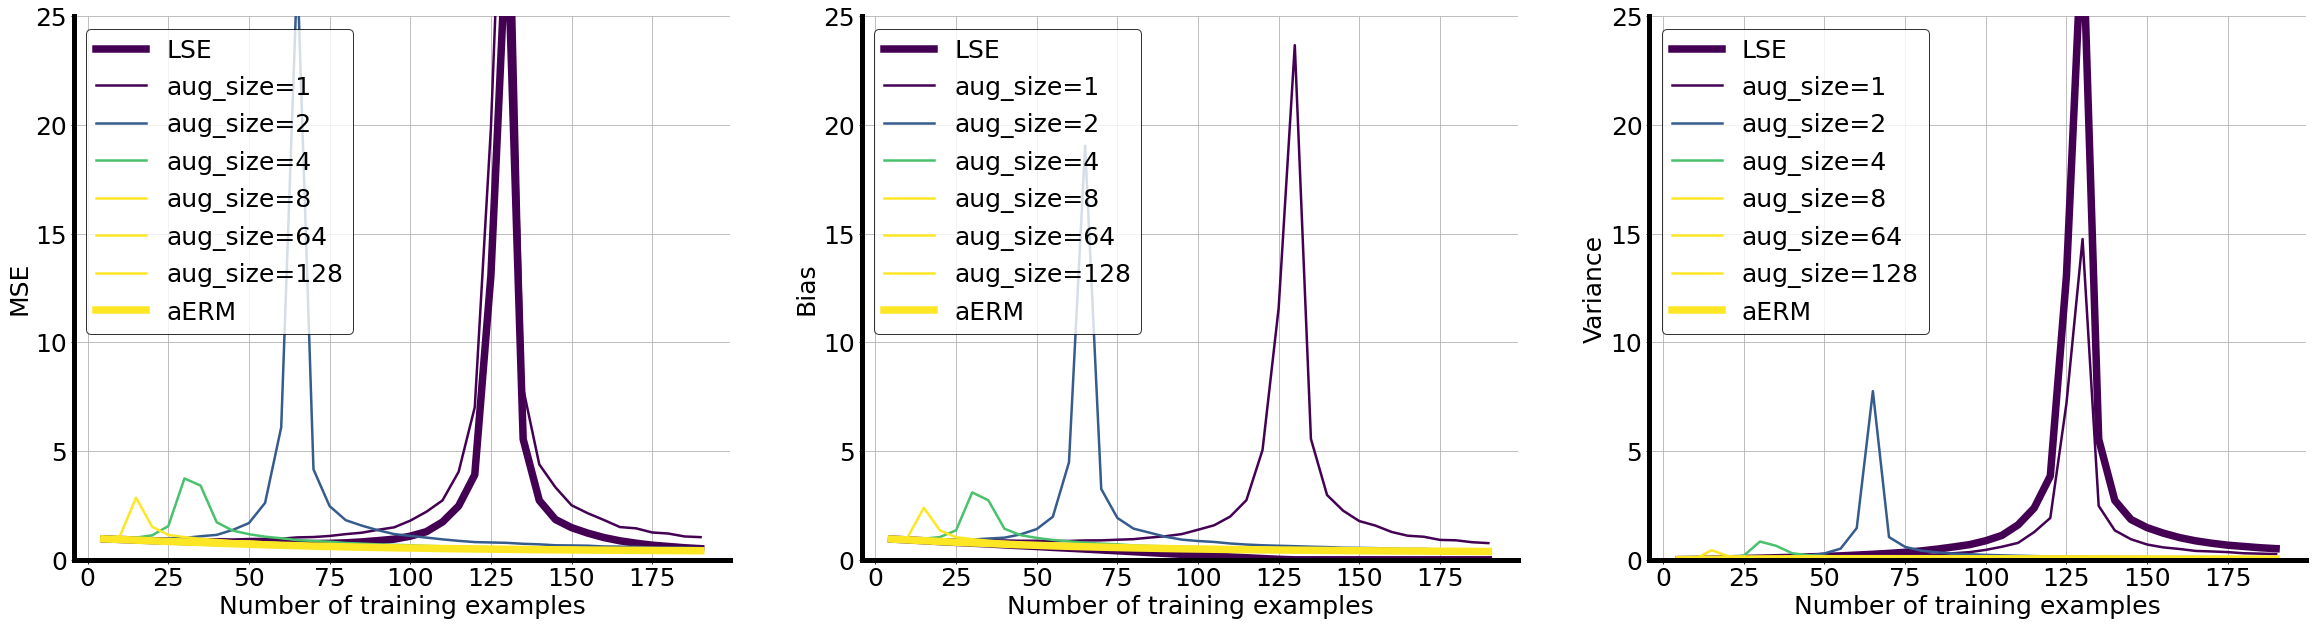

In [134]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 8)
linewidth = 2.5
legendsize = 25
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 5

plt.figure(figsize=(40, 10))
y_min = 0; y_max = 25
tick_size = 25

x_ax = sample_list
ax = plt.subplot(1,3,1)
plt.plot(x_ax, risk_lse_mean,  linewidth=3 * linewidth, label='LSE', c=viridis(0))
#plt.fill_between(x_ax, risk_lse_mean - 1.96 * risk_lse_std,  risk_lse_mean+ risk_lse_std, color=viridis(0),alpha=0.3)
for i in range(len(ridge_params)):
    for l in range(len(aug_size)):
        plt.plot(x_ax, risk_ridge_finite_mean[i, l, :], label='aug_size=' + str(aug_size[l]), linewidth=linewidth, c=viridis(l /3), ls='-')
        #plt.fill_between(x_ax, risk_ridge_finite_mean[i, l, :]-1.15*risk_ridge_finite_std[i, l, :],risk_ridge_finite_mean[i, l, :]+1.15*risk_ridge_finite_std[i, l, :], color=viridis(l /3), alpha=0.3)
for i in range(len(ridge_params)):
    plt.plot(x_ax, risk_ridge_mean[i, :], label='aERM', linewidth=3*linewidth, c=viridis(len(aug_size)/3), ls='-')
    #plt.fill_between(x_ax, risk_ridge_mean[i, :]-1.15*risk_ridge_std[i, :],risk_ridge_mean[i, :]+1.15*risk_ridge_std[i, :], color=viridis(l /3), alpha=0.3)
plt.legend(loc="upper right", prop={'size': 18})
plt.xlabel('Number of training examples', fontsize=25)
plt.ylabel('MSE', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
leg = plt.legend(loc="upper left", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
plt.grid(True)
leg.get_frame().set_edgecolor('black')
#plt.title("Adding Gaussian Noise, MSE", fontsize=25)

ax = plt.subplot(1,3,2)
plt.plot(x_ax, bias_lse_mean,  linewidth=3 * linewidth, label='LSE', c=viridis(0))
for i in range(len(ridge_params)):
    for l in range(len(aug_size)):
        plt.plot(x_ax, bias_ridge_finite_mean[i, l, :], label='aug_size=' + str(aug_size[l]), linewidth=linewidth, c=viridis(l /3), ls='-')
        #plt.fill_between(x_ax, bias_ridge_finite_mean[i, l, :]-1.15*bias_ridge_finite_std[i, l, :],bias_ridge_finite_mean[i, l, :]+1.15*bias_ridge_finite_std[i, l, :], color=viridis(l /3), alpha=0.3)
for i in range(len(ridge_params)):
    plt.plot(x_ax, bias_ridge_mean[i, :], label='aERM', linewidth=3*linewidth, c=viridis(len(aug_size)/3), ls='-')
    #plt.fill_between(x_ax, bias_ridge_mean[i, :]-1.15*bias_ridge_std[i, :],bias_ridge_mean[i, :]+1.15*bias_ridge_std[i, :], color=viridis(l /3), alpha=0.3)
plt.legend(loc="upper right", prop={'size': 18})
plt.xlabel('Number of training examples', fontsize=25)
plt.ylabel('Bias', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
leg = plt.legend(loc="upper left", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.grid(True)
#plt.title("Adding Gaussian Noise, Bias", fontsize=25)

ax = plt.subplot(1,3,3)
plt.plot(x_ax, var_lse_mean,  linewidth=3 * linewidth, label='LSE', c=viridis(0))
for i in range(len(ridge_params)):
    for l in range(len(aug_size)):
        plt.plot(x_ax, var_ridge_finite_mean[i, l, :], label='aug_size=' + str(aug_size[l]), linewidth=linewidth, c=viridis(l /3), ls='-')
        #plt.fill_between(x_ax, var_ridge_finite_mean[i, l, :]-1.15*var_ridge_finite_std[i, l, :],var_ridge_finite_mean[i, l, :]+1.15*var_ridge_finite_std[i, l, :], color=viridis(l /3), alpha=0.3)
    plt.plot(x_ax, var_ridge_mean[i, :], label='aERM', linewidth=3*linewidth, c=viridis(len(aug_size)/3), ls='-')
    #plt.fill_between(x_ax, var_ridge_mean[i, :]-1.15*var_ridge_std[i, :],var_ridge_mean[i, :]+1.15*var_ridge_std[i, :], color=viridis(l /3), alpha=0.3)
plt.xlabel('Number of training examples', fontsize=25)
plt.ylabel('Variance', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
leg = plt.legend(loc="upper left", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
plt.grid(True)
leg.get_frame().set_edgecolor('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.title("Adding Gaussian Noise, Variance", fontsize=25)

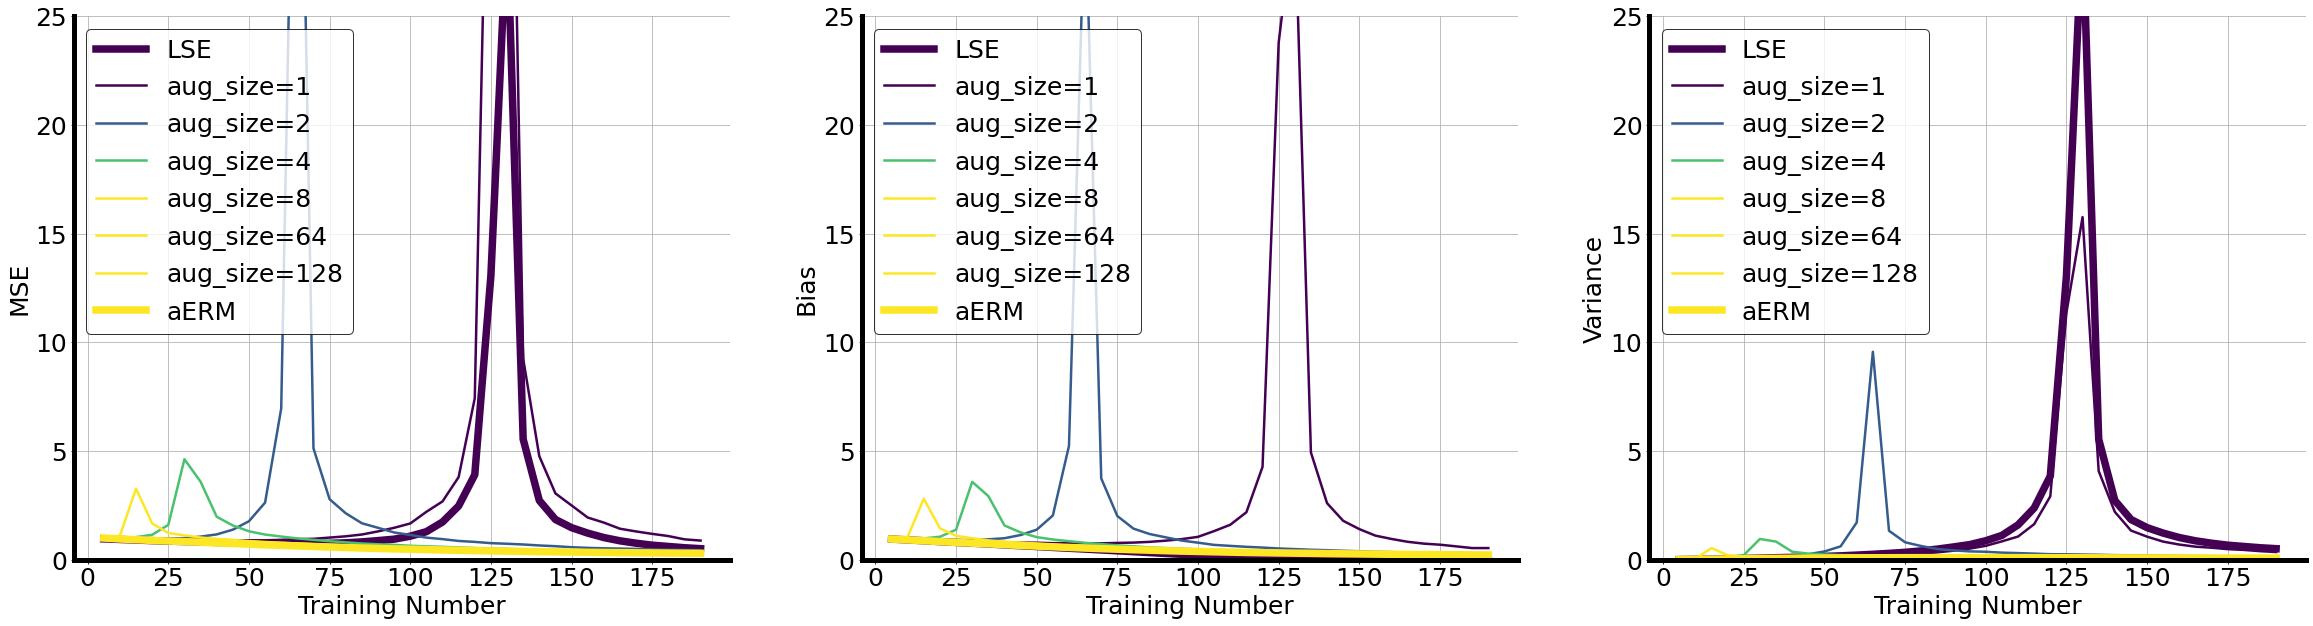

In [135]:
plt.figure(figsize=(40, 10))
fac = 0.8
#marker = ['x', '.', 'o', 'D', '+', 'P', 'X']
marker = ['o', 'D', 'P', 'X', 'x', '+', '.']
markersize = [fac * 10, fac * 14, fac * 18, fac* 19, fac*20, fac*21, fac*22]
x_ax = sample_list
ax = plt.subplot(1,3,1)
plt.plot(x_ax, risk_lse_mean,  linewidth=3 * linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    for l in range(len(aug_size)):
        plt.plot(x_ax, risk_crop_finite_mean[i, l, :], label='aug_size=' + str(aug_size[l]), linewidth=linewidth, c=viridis(l /3), ls='-')
       # plt.fill_between(x_ax, risk_crop_finite_mean[i, l, :]-1.15*risk_crop_finite_std[i, l, :],risk_crop_finite_mean[i, l, :]+1.15*risk_crop_finite_std[i, l, :], color=viridis(l /3), alpha=0.3)
for i in range(len(crop_params)):
    plt.plot(x_ax, risk_crop_mean[i, :], label='aERM', linewidth=3*linewidth, c=viridis(len(aug_size)/3), ls='-')
    #plt.fill_between(x_ax, risk_crop_mean[i, :]-1.15*risk_crop_std[i, :],risk_crop_mean[i, :]+1.15*risk_crop_std[i, :], color=viridis(l /3), alpha=0.3)
plt.xlabel('Training Number', fontsize=25)
plt.ylabel('MSE', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
leg = plt.legend(loc="upper left", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
#plt.title("Random Mask, MSE", fontsize=25)

ax = plt.subplot(1,3,2)
plt.plot(x_ax, bias_lse_mean,  linewidth=3 * linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    for l in range(len(aug_size)):
        plt.plot(x_ax, bias_crop_finite_mean[i, l, :], label='aug_size=' + str(aug_size[l]), linewidth=linewidth, c=viridis(l /3), ls='-')
        #plt.fill_between(x_ax, bias_crop_finite_mean[i, l, :]-1.15*bias_crop_finite_std[i, l, :],bias_crop_finite_mean[i, l, :]+1.15*bias_crop_finite_std[i, l, :], color=viridis(l /3), alpha=0.3)
for i in range(len(crop_params)):
    plt.plot(x_ax, bias_crop_mean[i, :], label='aERM', linewidth=3*linewidth, c=viridis(len(aug_size)/3), ls='-')
    #plt.fill_between(x_ax, bias_crop_mean[i, :]-1.15*bias_crop_std[i, :],bias_crop_mean[i, :]+1.15*bias_crop_std[i, :], color=viridis(l /3), alpha=0.3)
plt.legend(loc="upper right", prop={'size': 18})
plt.xlabel('Training Number', fontsize=25)
plt.ylabel('Bias', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
#plt.title("Random Mask, Bias", fontsize=25)
leg = plt.legend(loc="upper left", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)

ax = plt.subplot(1,3,3)
plt.plot(x_ax, var_lse_mean,   linewidth=3 * linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    for l in range(len(aug_size)):
        plt.plot(x_ax, var_crop_finite_mean[i, l, :], label='aug_size=' + str(aug_size[l]), linewidth=linewidth, c=viridis(l /3), ls='-')
        #plt.fill_between(x_ax, var_crop_finite_mean[i, l, :]-1.15*var_crop_finite_std[i, l, :],var_crop_finite_mean[i, l, :]+1.15*var_crop_finite_std[i, l, :], #color=viridis(l /3), alpha=0.3)
for i in range(len(crop_params)):
    plt.plot(x_ax, var_crop_mean[i, :], label='aERM', linewidth=3*linewidth, c=viridis(len(aug_size)/3), ls='-')
    #plt.fill_between(x_ax, var_crop_mean[i, :]-1.15*var_crop_std[i, :],var_crop_mean[i, :]+1.15*var_crop_std[i, :], color=viridis(l /3), alpha=0.3)
plt.legend(loc="upper right", prop={'size': 18})
plt.xlabel('Training Number', fontsize=25)
plt.ylabel('Variance', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid(True)
plt.ylim(y_min, y_max)
leg = plt.legend(loc="upper left", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
#plt.title("Random Mask, Variance", fontsize=25)